In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from nltk.tokenize import word_tokenize
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raymondeds/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df_reviews = pd.read_csv('../data/reviews.csv')
df_submissions = pd.read_csv('../data/Submissions.csv')
df_dec = pd.read_csv('../data/decision.csv')
df_keyword = pd.read_csv('../data/submission_keyword.csv')

df_rs = pd.merge(df_reviews[['rating_int','confidence_int','review','forum']], df_submissions[['abstract','id','conf_year']], left_on='forum', right_on='id', how = 'inner')
df_rs['review'] = df_rs['review'].str.lower()
df_rs['abstract'] = df_rs['abstract'].str.lower()
df_rs['review_tokens'] = df_rs['review'].apply(word_tokenize)
df_rs['review_num_tokens'] = df_rs['review_tokens'].apply(len)

df_data = pd.merge(df_rs, df_dec, left_on='forum', right_on='forum', how = 'inner').drop([
                                                         'id_x',
                                                         'id_y',
                                                         'tcdate',
                                                         'tmdate',
                                                         'number',
                                                         'confidence'],axis = 1)

df_data

,rating_int,confidence_int,review,forum,abstract,conf_year,review_tokens,review_num_tokens,replyto,title,decision,comment,conf_name
0,6,4.0,there is a lot of recent work on link-predicti...,tGZu6DlbreV,this paper studies learning logic rules for re...,2021,"[there, is, a, lot, of, recent, work, on, link...",1537,tGZu6DlbreV,Final Decision,Accept (Poster),There is a consensus among the reviewers that ...,ICLR2021
1,7,4.0,"in this paper, the author proposes rnnlogic fo...",tGZu6DlbreV,this paper studies learning logic rules for re...,2021,"[in, this, paper, ,, the, author, proposes, rn...",722,tGZu6DlbreV,Final Decision,Accept (Poster),There is a consensus among the reviewers that ...,ICLR2021
2,6,2.0,this paper focuses on learning logic rules via...,tGZu6DlbreV,this paper studies learning logic rules for re...,2021,"[this, paper, focuses, on, learning, logic, ru...",236,tGZu6DlbreV,Final Decision,Accept (Poster),There is a consensus among the reviewers that ...,ICLR2021
3,8,1.0,"in this work, the authors illustrate an approa...",tGZu6DlbreV,this paper studies learning logic rules for re...,2021,"[in, this, work, ,, the, authors, illustrate, ...",121,tGZu6DlbreV,Final Decision,Accept (Poster),There is a consensus among the reviewers that ...,ICLR2021
4,6,4.0,pros:\n\n- the different attention techniques ...,uKhGRvM8QNH,"knowledge distillation, in which a student mod...",2021,"[pros, :, -, the, different, attention, techni...",338,uKhGRvM8QNH,Final Decision,Accept (Poster),"After the rebuttal stage, all reviewers lean p...",ICLR2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25163,4,4.0,the author proposes the use of low-rank matrix...,rkaRFYcgl,deep learning consists in training neural netw...,2017,"[the, author, proposes, the, use, of, low-rank...",383,rkaRFYcgl,ICLR committee final decision,Reject,The reviewers seem to agree that the framework...,ICLR2017
25164,5,NaN,the paper proposes a low-rank version of pass-...,rkaRFYcgl,deep learning consists in training neural netw...,2017,"[the, paper, proposes, a, low-rank, version, o...",82,rkaRFYcgl,ICLR committee final decision,Reject,The reviewers seem to agree that the framework...,ICLR2017
25165,6,4.0,the authors study the use of low-rank approxim...,rkaRFYcgl,deep learning consists in training neural netw...,2017,"[the, authors, study, the, use, of, low-rank, ...",209,rkaRFYcgl,ICLR committee final decision,Reject,The reviewers seem to agree that the framework...,ICLR2017
25166,6,4.0,​there have been numerous works ​on learning f...,BkUDvt5gg,this paper presents a simple end-to-end model ...,2017,"[​there, have, been, numerous, works, ​on, lea...",326,BkUDvt5gg,ICLR committee final decision,Reject,Without revisions to this paper or a rebuttal ...,ICLR2017


# T-NES Clustering

In [24]:
X = df_data[features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_scaled.min()

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

-3.350815398866796

In [16]:
le = LabelEncoder()
df_data['decision_num'] = le.fit_transform(df_data['decision'])
df_data = df_data.dropna()




/var/folders/v9/8whxr3fd1mv_pwkjh0kn920m0000gn/T/ipykernel_19247/2743484965.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['decision_num'] = le.fit_transform(df_data['decision'])
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/nlp/lib/

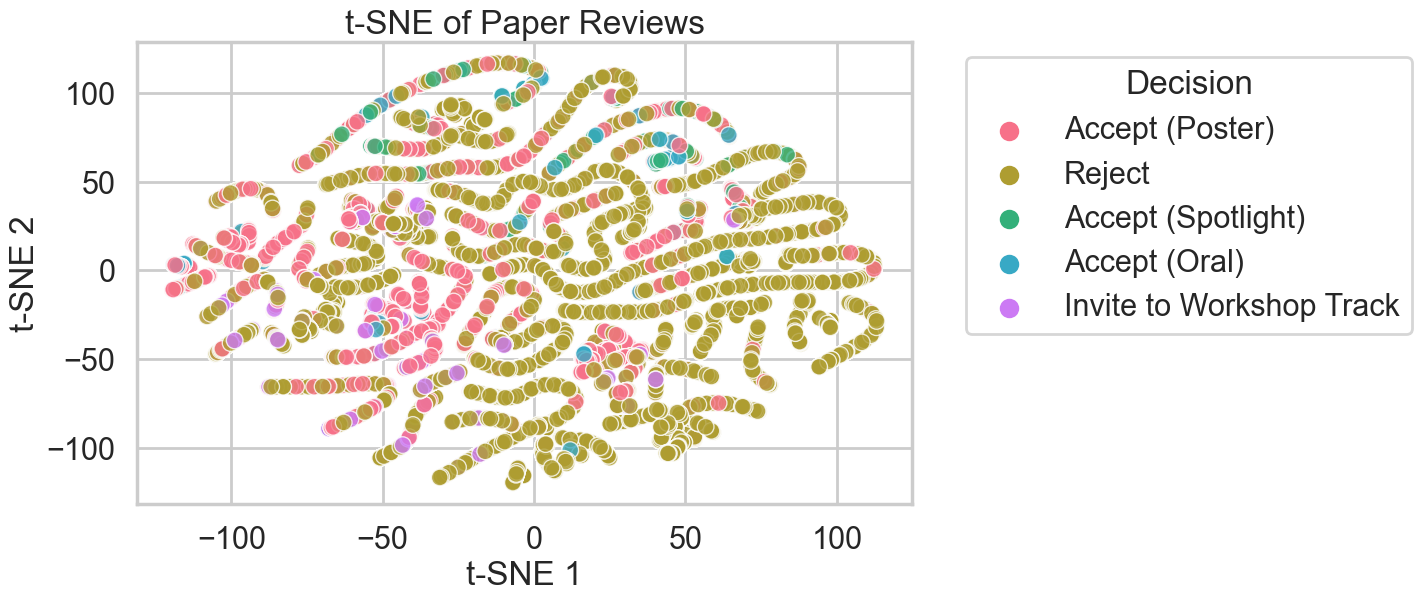

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert categorical variable 'decision' to numerical
le = LabelEncoder()
df_data['decision_num'] = le.fit_transform(df_data['decision'])
df_data = df_data.dropna()

# Features to be used in t-SNE
features = ['rating_int', 'conf_year', 'review_num_tokens', 'confidence_int']
X = df_data[features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame
df_data['tsne-2d-one'] = X_tsne[:, 0]
df_data['tsne-2d-two'] = X_tsne[:, 1]

# Define a custom color palette with 5 colors
custom_palette = sns.color_palette('husl', 5)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='decision',
    palette=custom_palette,
    data=df_data,
    alpha=0.8
)
plt.title('t-SNE of Paper Reviews')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Decision', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

TypeError: unhashable type: '_ColorPalette'

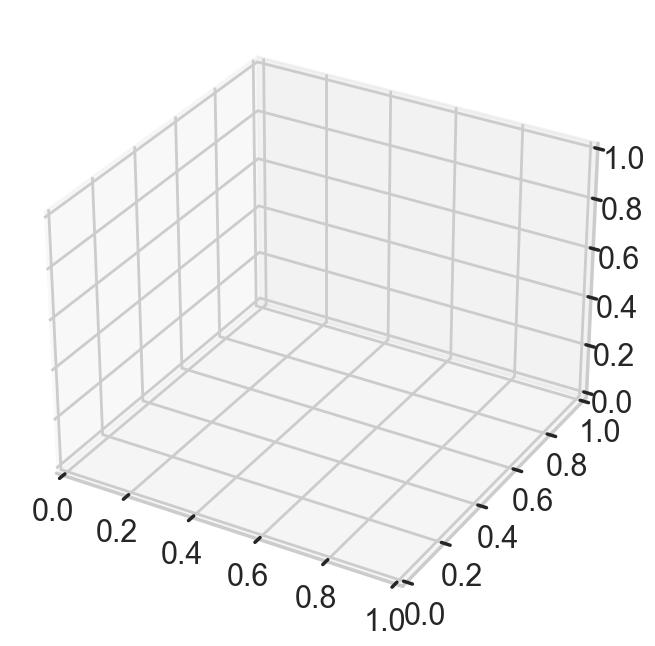

In [26]:
# Convert categorical variable 'decision' to numerical
le = LabelEncoder()
df_data['decision_num'] = le.fit_transform(df_data['decision'])

# Drop NaN values
df_data = df_data.dropna()

# Features to be used in t-SNE
features = ['rating_int', 'conf_year', 'review_num_tokens', 'confidence_int']
X = df_data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame
df_data['tsne-3d-one'] = X_tsne[:, 0]
df_data['tsne-3d-two'] = X_tsne[:, 1]
df_data['tsne-3d-three'] = X_tsne[:, 2]

# Define a custom color palette with 5 colors
custom_palette = sns.color_palette('husl', 5)

# Plot t-SNE results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=df_data['tsne-3d-one'],
    ys=df_data['tsne-3d-two'],
    zs=df_data['tsne-3d-three'],
    c=df_data['decision_num'],
    cmap=custom_palette,
    alpha=0.8
)

# Legend
legend_labels = le.classes_
legend = ax.legend(handles=scatter.legend_elements()[0], title='Decision', labels=legend_labels, loc='upper left')
ax.add_artist(legend)

# Axes labels and title
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('t-SNE of Paper Reviews')

plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

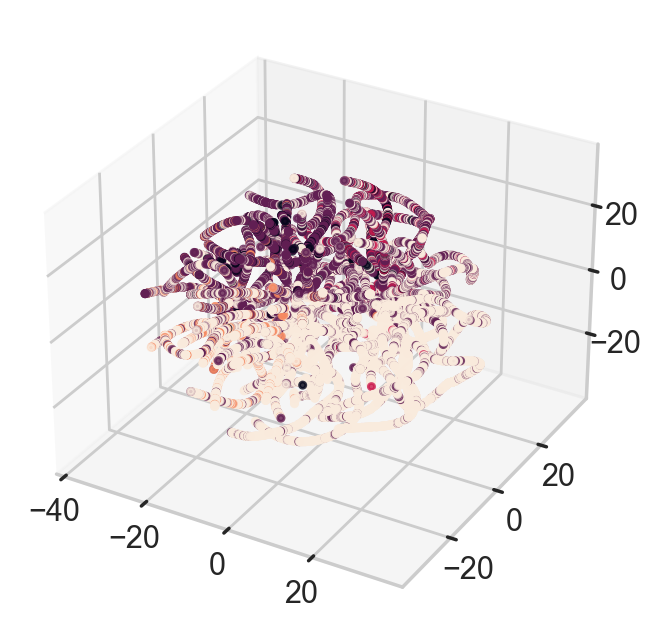

In [28]:
# Define a custom color palette with 5 colors
#custom_palette = sns.color_palette('husl', 5)

# Plot t-SNE results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=df_data['tsne-3d-one'],
    ys=df_data['tsne-3d-two'],
    zs=df_data['tsne-3d-three'],
    c=df_data['decision_num'],
    #cmap=custom_palette,
    alpha=0.8
)

# Legend
legend_labels = le.classes_
legend = ax.legend(handles=scatter.legend_elements()[0], title='Decision', labels=legend_labels, loc='upper left')
ax.add_artist(legend)

# Axes labels and title
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('t-SNE of Paper Reviews')

plt.show()

In [2]:
# Step 2: Import the necessary libraries
from transformers import pipeline
from transformers import AutoTokenizer

# Step 3: Load the pre-trained model and tokenizer
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Step 4: Define the text for sentiment analysis
text = "I love using Hugging Face's Transformers library! It's amazing."

# Step 5: Perform sentiment analysis
result = sentiment_analysis(text)

# Step 6: Display the result
print(result)

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'positive', 'score': 0.9873846769332886}]


In [ ]:
sentiment_analysis(df_data.review[0])

In [ ]:
def split_text(text, tokenizer, max_length=512):
    sentences = nltk.sent_tokenize(text)
    chunks = []
    chunk = ""
    for sentence in sentences:
        if len(tokenizer.encode(chunk + sentence, add_special_tokens=False)) <= max_length:
            chunk += " " + sentence
        else:
            chunks.append(chunk.strip())
            chunk = sentence
    if chunk:
        chunks.append(chunk.strip())
    return chunks

# Step 8: Perform sentiment analysis on each chunk
results = [sentiment_analysis(chunk) for chunk in chunks]

# Step 9: Aggregate the results
positive_score = sum(res[0]['score'] for res in results if res[0]['label'] == 'POSITIVE')
negative_score = sum(res[0]['score'] for res in results if res[0]['label'] == 'NEGATIVE')
